# 03 – Feature Engineering & Risk Index

**Author**: Namora Fernando <br>
**Date**: 2025-08-28 <br>
**Objective**: Engineer modeling-ready features and build a per-year inflation risk index from World Bank indicators:

1. Create change/volatility features (FX change, CPI volatility, Money Supply change).
2. Impute small gaps conservatively (country-wise).
3. Winsorize outliers per year.
4. Normalize per year and combine into a composite **Risk Score (0–100)**.
5. Export dataset for next steps and Power BI.

## 1. Imports & Paths (and Repro Setup)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Paths
INPUT_FILE  = "data_intermediate/cleaned_merged_inflation_data.csv"   # from 01
OUTPUT_DIR  = "data_intermediate"
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "inflation_data_with_risk_index.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

## 2. Load Data & Basic Checks

In [2]:
df = pd.read_csv(INPUT_FILE)

# Ensure proper types & ordering
df["Year"] = df["Year"].astype(int)
df = df.sort_values(["Country Name", "Year"]).reset_index(drop=True)

print(df.shape)
df.head()

(15918, 7)


,Country Name,Country Code,Year,CPI_AnnualChange,GDP_Growth,MoneySupply_GDPpct,ExchangeRate_LCUperUSD
0,Afghanistan,AFG,1960,NaN,NaN,NaN,17.196561
1,Afghanistan,AFG,1961,NaN,NaN,NaN,17.196561
2,Afghanistan,AFG,1962,NaN,NaN,NaN,17.196561
3,Afghanistan,AFG,1963,NaN,NaN,NaN,35.109645
4,Afghanistan,AFG,1964,NaN,NaN,NaN,38.692262


## 3. Feature Engineering (Changes, Volatility, Trends)

**Why these features?**

- **FX depreciation** is a classic inflation risk signal → use **YoY % change** of exchange rate.
- **CPI volatility** (rolling std) captures instability → use **3-year rolling std**.
- **Money supply growth** reflects monetary expansion → use **YoY % change**.
- **GDP growth** level already in data (we’ll smooth for reference too).

In [3]:
# Exchange Rate % Change (YoY) per country
df["ExchangeRate_ChangePct"] = (
    df.groupby("Country Name")["ExchangeRate_LCUperUSD"]
      .pct_change() * 100
)

# CPI rolling volatility (3-year rolling std)
df["CPI_RollingVol_3y"] = (
    df.groupby("Country Name")["CPI_AnnualChange"]
      .transform(lambda s: s.rolling(window=3, min_periods=2).std())
)

# Money Supply % Change (YoY) per country
df["MoneySupply_ChangePct"] = (
    df.groupby("Country Name")["MoneySupply_GDPpct"]
      .pct_change() * 100
)

# GDP 3y moving average (context only, not in index)
df["GDP_Growth_MA_3y"] = (
    df.groupby("Country Name")["GDP_Growth"]
      .transform(lambda s: s.rolling(window=3, min_periods=1).mean())
)

df.head(10)

C:\Users\namor\AppData\Local\Temp\ipykernel_17092\4004190335.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change() * 100
C:\Users\namor\AppData\Local\Temp\ipykernel_17092\4004190335.py:16: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change() * 100


,Country Name,Country Code,Year,CPI_AnnualChange,GDP_Growth,MoneySupply_GDPpct,ExchangeRate_LCUperUSD,ExchangeRate_ChangePct,CPI_RollingVol_3y,MoneySupply_ChangePct,GDP_Growth_MA_3y
0,Afghanistan,AFG,1960,NaN,NaN,NaN,17.196561,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1961,NaN,NaN,NaN,17.196561,0.000000,NaN,NaN,NaN
2,Afghanistan,AFG,1962,NaN,NaN,NaN,17.196561,0.000000,NaN,NaN,NaN
3,Afghanistan,AFG,1963,NaN,NaN,NaN,35.109645,104.166667,NaN,NaN,NaN
4,Afghanistan,AFG,1964,NaN,NaN,NaN,38.692262,10.204082,NaN,NaN,NaN
5,Afghanistan,AFG,1965,NaN,NaN,NaN,38.692262,0.000000,NaN,NaN,NaN
6,Afghanistan,AFG,1966,NaN,NaN,NaN,38.692262,0.000000,NaN,NaN,NaN
7,Afghanistan,AFG,1967,NaN,NaN,NaN,38.692262,0.000000,NaN,NaN,NaN
8,Afghanistan,AFG,1968,NaN,NaN,NaN,38.692262,0.000000,NaN,NaN,NaN
9,Afghanistan,AFG,1969,NaN,NaN,NaN,38.692262,0.000000,NaN,NaN,NaN


## 4. Conservative Imputation (Country-wise, small gaps only)

**Policy**: we keep 01 as the non-imputed “truth”. <br>
Here we impute **only small gaps** so the index can be computed:

- Linear interpolate within country (`limit=2` years).
- Then `ffill`/`bfill` inside country. If an entire country series is missing for an indicator, values stay NaN.

In [4]:
cols_to_impute = [
    "CPI_AnnualChange",
    "GDP_Growth",
    "ExchangeRate_ChangePct",
    "MoneySupply_ChangePct"
]

# Save before impute, to flag which has been filled from NaN previously
pre_na = {col: df[col].isna() for col in cols_to_impute}

# Ensure sorting before interpolation
df = df.sort_values(["Country Name", "Year"]).reset_index(drop=True)

for col in cols_to_impute:
    # linear interpolation for small gaps within each country
    df[col] = (
        df.groupby("Country Name")[col]
          .apply(lambda s: s.interpolate(method="linear", limit=2, limit_direction="both"))
          .reset_index(level=0, drop=True)
    )
    # fill edges within country (still conservative)
    df[col] = df.groupby("Country Name")[col].transform(lambda s: s.ffill().bfill())

    # flag which previously NaN, that has been filled
    df[f"{col}_filled_from_na"] = pre_na[col] & df[col].notna()

# Missing summary after impute
df[cols_to_impute].isna().sum()

CPI_AnnualChange          1430
GDP_Growth                  65
ExchangeRate_ChangePct    3114
MoneySupply_ChangePct     3022
dtype: int64

After conservative impute, missing value still left especially on **FX change** and **Money Supply change**, which common since original raw data lack availability/change stepwise. Flag `*_filled_from_na` is available for transparancies.

## 5. Per-Year Outlier Handling (Log + Winsorization)

Some indicators (CPI, FX, Money Supply) are highly skewed with extreme outliers (e.g. hyperinflation, currency crash). This is shown on previous notebook `02_exploratory_analysis.ipynb`. <br>

- To stabilize distribution before clipping, we first apply **log transform (`log1p`)**, then winsorize within each year (1st–99th percentiles).
- GDP Growth is relatively symmetric → we winsorize directly without log.

In [5]:
# Apply log1p transform for skewed indicators
# note: clip lower bound to -0.99 to avoid log(<= -1)
df["CPI_log"] = np.log1p(df["CPI_AnnualChange"].clip(lower=-0.99))
df["FX_log"]  = np.log1p(df["ExchangeRate_ChangePct"].clip(lower=-0.99))
df["MS_log"]  = np.log1p(df["MoneySupply_ChangePct"].clip(lower=-0.99))

def winsorize_by_year(frame, col, lower=1, upper=99):
    def _clip(s):
        lo, hi = s.quantile(lower/100), s.quantile(upper/100)
        return s.clip(lo, hi)
    return frame.groupby("Year")[col].transform(_clip)

# Columns to winsorize
winsor_cols = {
    "CPI_log": (1, 99),
    "FX_log": (1, 99),
    "MS_log": (1, 99),
    "GDP_Growth": (1, 99)
}

for c, (lo, hi) in winsor_cols.items():
    df[f"{c}_win"] = winsorize_by_year(df, c, lower=lo, upper=hi)

df[[c for c in df.columns if c.endswith("_win")]].head()

,CPI_log_win,FX_log_win,MS_log_win,GDP_Growth_win
0,2.616393,0.000000,1.13082,-9.431974
1,2.616393,0.000000,1.13082,-9.431974
2,2.616393,0.000000,1.13082,-9.431974
3,2.616393,4.151438,1.13082,-9.431974
4,2.616393,2.416278,1.13082,-9.431974


After log-transform + winsorization, the extreme outliers are clipped but the overall distributional shape is preserved.  
- `0.000000` values in FX and Money Supply may represent either true zero changes (flat year-to-year data) or artifacts from interpolation/fill of missing values.  
- GDP Growth is clipped directly (without log), consistent with its more symmetric distribution.  

This step prevents hyper-outliers from dominating the later z-score normalization.

## 6. Per-Year Normalization (Z-Scores)

We normalize the winsorized values within each year using **z-scores**,  
so comparisons are made only among countries in the same year (same global context).

- CPI ↑ → higher z = higher risk  
- FX depreciation ↑ → higher z = higher risk  
- Money Supply ↑ → higher z = higher risk  
- GDP Growth ↑ → lower risk ⇒ we invert the sign

On this project, we treat higher GDP growth as reducing inflation risk, consistent with the stability argument. The sign is inverted in the composite index.

In [6]:
def zscore_by_year(frame, col):
    def _z(s):
        mu = s.mean()
        sd = s.std(ddof=0) # since assumed the dataset represents the population
        if sd == 0 or np.isnan(sd):
            return pd.Series(np.zeros(len(s)), index=s.index)
        return (s - mu) / sd
    return frame.groupby("Year")[col].transform(_z)

# Compute per-year z-scores
df["z_CPI"] = zscore_by_year(df, "CPI_log_win")
df["z_FX"]  = zscore_by_year(df, "FX_log_win")
df["z_MS"]  = zscore_by_year(df, "MS_log_win")
df["z_GDP"] = zscore_by_year(df, "GDP_Growth_win")

# Invert GDP (higher growth = lower risk)
df["z_GDP_inv"] = -df["z_GDP"]

df[["Year","z_CPI","z_FX","z_MS","z_GDP","z_GDP_inv"]].head()

,Year,z_CPI,z_FX,z_MS,z_GDP,z_GDP_inv
0,1960,0.665760,-0.033170,0.633485,-2.388371,2.388371
1,1961,0.637773,-0.013548,0.662564,-2.331492,2.331492
2,1962,0.616062,-0.187294,0.523760,-2.704354,2.704354
3,1963,0.596935,4.843493,0.519742,-2.587929,2.587929
4,1964,0.587028,2.343264,0.672469,-2.803802,2.803802


Per-year z-scores show that indicators are now centered around 0 and scaled by yearly variability.  
- Positive z_CPI / z_FX / z_MS → above-average risk in that year  
- Negative z-values → below-average risk  
- GDP is inverted into `z_GDP_inv` so higher growth reduces risk contribution.  
This ensures comparability across countries within the same year, regardless of global inflation regimes.

## 7. Composite Risk Index (per Year), then 0–100 Scaling

Weights (sum to 1) — weights are currently fixed, but can be redefined in code if future adjustments are needed:
- CPI: **0.40**
- FX change: **0.25**
- Money Supply change: **0.20**
- GDP growth (inverted): **0.15**

Weights are fixed at this stage for consistency across countries and years.”

In [7]:
weights = {
    "z_CPI": 0.40,
    "z_FX":  0.25,
    "z_MS":  0.20,
    "z_GDP_inv": 0.15
}

df["Risk_Index_Z"] = (
    weights["z_CPI"]     * df["z_CPI"] +
    weights["z_FX"]      * df["z_FX"]  +
    weights["z_MS"]      * df["z_MS"]  +
    weights["z_GDP_inv"] * df["z_GDP_inv"]
)

def minmax_0_100_by_year(frame, col):
    def _scale(s):
        lo, hi = s.min(), s.max()
        if hi == lo:
            return pd.Series(np.full(len(s), 50.0), index=s.index)
        return (s - lo) / (hi - lo) * 100.0
    return frame.groupby("Year")[col].transform(_scale)

df["Risk_Score_0_100"] = minmax_0_100_by_year(df, "Risk_Index_Z")

df[["Country Name","Year","Risk_Index_Z","Risk_Score_0_100"]].head(10)

,Country Name,Year,Risk_Index_Z,Risk_Score_0_100
0,Afghanistan,1960,0.742964,73.682224
1,Afghanistan,1961,0.733959,77.382261
2,Afghanistan,1962,0.710006,63.251059
3,Afghanistan,1963,1.941785,88.498185
4,Afghanistan,1964,1.375691,79.236123
5,Afghanistan,1965,0.698301,57.730757
6,Afghanistan,1966,0.686874,60.870361
7,Afghanistan,1967,0.553229,61.425498
8,Afghanistan,1968,0.554303,70.674385
9,Afghanistan,1969,0.667981,77.199948


The composite risk index is constructed from standardized (z-score) indicators, with weights reflecting economic intuition:  
- CPI inflation (40%) – main inflation risk driver  
- Exchange rate depreciation (25%) – external sector pressure  
- Money supply growth (20%) – monetary expansion risk  
- GDP growth (inverted, 15%) – weak growth amplifies vulnerability  

After combining, the index is scaled to 0–100 **within each year**.  
- This ensures comparability across countries in the same macro context (same year).  
- It also means the "100" score is relative to the riskiest country that year, not an absolute global threshold.  
- Mid-range countries typically cluster around 40–60, while severe crisis cases (e.g., hyperinflation episodes) spike close to 100.  

## 8. Quick Sanity Checks (Top Risky Countries in Latest Year)

In [8]:
latest_year = int(df["Year"].max())
cols_view = [
    "Country Name", "Year", "Risk_Score_0_100",
    "CPI_AnnualChange", "ExchangeRate_ChangePct", "MoneySupply_ChangePct", "GDP_Growth"
]
top_latest = (
    df[df["Year"] == latest_year]
      .sort_values("Risk_Score_0_100", ascending=False)
      .head(15)[cols_view]
)
top_latest

,Country Name,Year,Risk_Score_0_100,CPI_AnnualChange,ExchangeRate_ChangePct,MoneySupply_ChangePct,GDP_Growth
13351,South Sudan,2024,100.000000,91.440822,132.508954,0.000000,-10.793365
8333,Lebanon,2024,85.334559,45.243042,545.015990,0.000000,-0.760584
13998,Sudan,2024,82.922681,138.808460,0.000000,0.000000,-13.493292
14816,Turkiye,2024,78.547617,58.506451,38.196474,0.000000,3.184024
10837,Nigeria,2024,76.091848,33.242097,129.227960,0.000000,3.426439
4026,"Egypt, Arab Rep.",2024,61.588835,28.270590,47.909123,-4.253268,2.399169
15852,Zambia,2024,61.470963,14.985626,29.459705,0.000000,4.043148
9046,Malawi,2024,60.923006,32.179650,0.000000,0.000000,1.826850
6972,"Iran, Islamic Rep.",2024,59.357760,32.455871,0.000000,0.000000,3.040000
486,Angola,2024,56.857224,28.240495,26.981094,-19.740280,4.423905


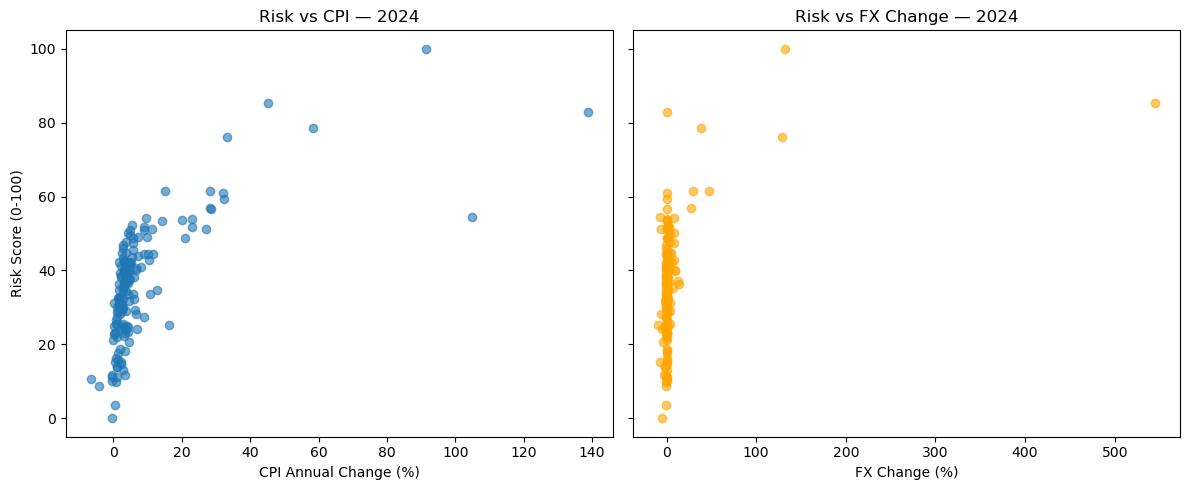

In [9]:
latest_year = int(df["Year"].max())
df_latest = df[df["Year"] == latest_year]

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Risk vs CPI
axes[0].scatter(df_latest["CPI_AnnualChange"], df_latest["Risk_Score_0_100"], alpha=0.6)
axes[0].set_xlabel("CPI Annual Change (%)")
axes[0].set_ylabel("Risk Score (0-100)")
axes[0].set_title(f"Risk vs CPI — {latest_year}")

# Risk vs FX depreciation
axes[1].scatter(df_latest["ExchangeRate_ChangePct"], df_latest["Risk_Score_0_100"], alpha=0.6, color="orange")
axes[1].set_xlabel("FX Change (%)")
axes[1].set_title(f"Risk vs FX Change — {latest_year}")

plt.tight_layout()
plt.show()

The top-ranked countries in the most recent year align with expectations:  
- **Hyperinflation / severe macro crises** (e.g., South Sudan, Lebanon) appear at the top with scores near 100.  
- High CPI growth combined with sharp FX depreciation are the main drivers behind extreme risk levels.  
- Countries with moderate inflation but negative GDP growth (e.g., Sudan, Turkiye) are also flagged due to compounding vulnerabilities.  
- Many stable economies remain below ~30–40, confirming that the index is able to distinguish structural crises from normal inflationary environments.  

> Scatter plots also confirm that higher inflation and sharper FX depreciation generally align with higher composite risk scores, validating the index design.

This sanity check validates that the composite index captures known high-risk episodes and produces a reasonable country ranking.  

## 9. Save Output

In [10]:
df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved with risk index → {OUTPUT_FILE}")
print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")

Saved with risk index → data_intermediate\inflation_data_with_risk_index.csv
Rows: 15,918 | Columns: 29


## 10. Summary

- Engineered features: FX % change, CPI 3y volatility, Money Supply % change, GDP 3y MA.
- Conservative imputation within countries to close small gaps.
- Per-year winsorization (1–99th pct) and z-score normalization.
- Composite Risk Index (CPI↑, FX↑, MS↑, GDP↓) with weights (0.40, 0.25, 0.20, 0.15).
- Scaled to Risk_Score_0_100 per year for clear cross-country comparison.
- Exported `inflation_data_with_risk_index.csv` for next steps.